## rV^2 = cst?


In [1]:
import sys,os
sys.path.append('../')

# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from datetime import datetime

# Custom
import functions as f
# import plotUtils as pu

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PARAMS = {'save_data':        False,
          'data_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
          'save_dir':         '/home/arthur/results/ck22model/Tests/',
          'ibtracs_path':     '/home/arthur/data/ibtracs/IBTrACS.ALL.v04r00.nc',
          
          'save_figs':        False,
          'save_dir_figs':    '/home/arthur/results/ck22model/SAR_dataset_initial_figs/',
          
          'Rmax_1D_bound':    150, # km
          'vars_of_interest': ['wind_speed', 'lon', 'lat', 'track_vmax', 'distance_to_coast', 'cyclone_speed', 'cyclone_speed_std', 'rotation_angle', 'rotation_angle_std', 
                               'vmax', 'rmax', 'tco_radii_ms_all', 'tco_radii_ms_FR', 'tco_radii_ms_FL', 'tco_radii_ms_RR', 'tco_radii_ms_RL', 'cyclone_category']
}

### OPEN DATA
all_data = glob.glob(PARAMS['data_dir'] + "*.nc")
print("Total number of files:", len(all_data))
# ds_all = xr.open_mfdataset(PARAMS['data_dir'] + '*.nc')

ds_ibt = xr.open_dataset(PARAMS['ibtracs_path'])

Total number of files: 335


In [3]:
dsg = xr.open_dataset('/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc')

### Add intensification parameters
dsg2 = xr.open_dataset('/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_17102022_with_extra_params.nc')
dsg['Vmax_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_smth_IBT']),
    coords={'time': dsg.time}
)
dsg['Vmax_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_smth_IBT']),
    coords={'time': dsg.time}
)

### Kinetic energy
K1_SAR = dsg['Vmax_1D'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R17_1D'] * 1000) ** 2)
K2_SAR = dsg['R17_1D'] * 1000 * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_1D'] ** 2)
K1_IBT = dsg['Vmax_IBT'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R34_IBT']) ** 2) 
K2_IBT = dsg['R34_IBT'] * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_IBT'] ** 2)

dsg['dKdt_SAR'] = K1_SAR + K2_SAR
dsg['dKdt_IBT'] = K1_IBT + K2_IBT

### rV^2 = cst?

In [4]:
### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
# dsg = dsg.where(dsg.lon_center < -50, drop=True) # Keep only USA best-track agencies
# dsg = dsg.where(dsg.distance_to_coast > 200000, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

print('SAR Mean Rmax = {:.0f} km'.format(dsg.Rmax_1D.mean()))
print('SAR Mean R64  = {:.0f} km'.format(dsg.R33_1D.mean()))
print('SAR Mean R34  = {:.0f} km'.format(dsg.R17_1D.mean()))

Nb of storms: 195
SAR Mean Rmax = 34 km
SAR Mean R64  = 57 km
SAR Mean R34  = 138 km


In [5]:
# ITERATE
listOfDatasets = []
rf             = np.linspace(1, 10, 37)
# rf             = np.linspace(1, 10, 91)
DSs            = dsg.mean(dim='theta', skipna=True)

for t in tqdm(np.arange(len(DSs.time))):
    ds  = DSs.isel(time=t)
    
    dsr = xr.Dataset(
        data_vars={'ws': ('r_star', np.array(ds.wind_speed / ds.Vmax_1D)),},
        coords={'r_star': np.array(ds.rad / (ds.Rmax_1D * 1000))}
    )
    
    listOfDatasets.append(dsr.interp(coords={'r_star': rf}))

print('Concatenating...')
dss = xr.concat(listOfDatasets, dim='i')
print('Concatenation ended.')

100%|████████████████████████████████████████| 195/195 [00:01<00:00, 165.37it/s]

Concatenating...
Concatenation ended.


100%|████████████████████████████████████████| 195/195 [00:00<00:00, 549.30it/s]


Text(0.5, 0, 'r / rm')

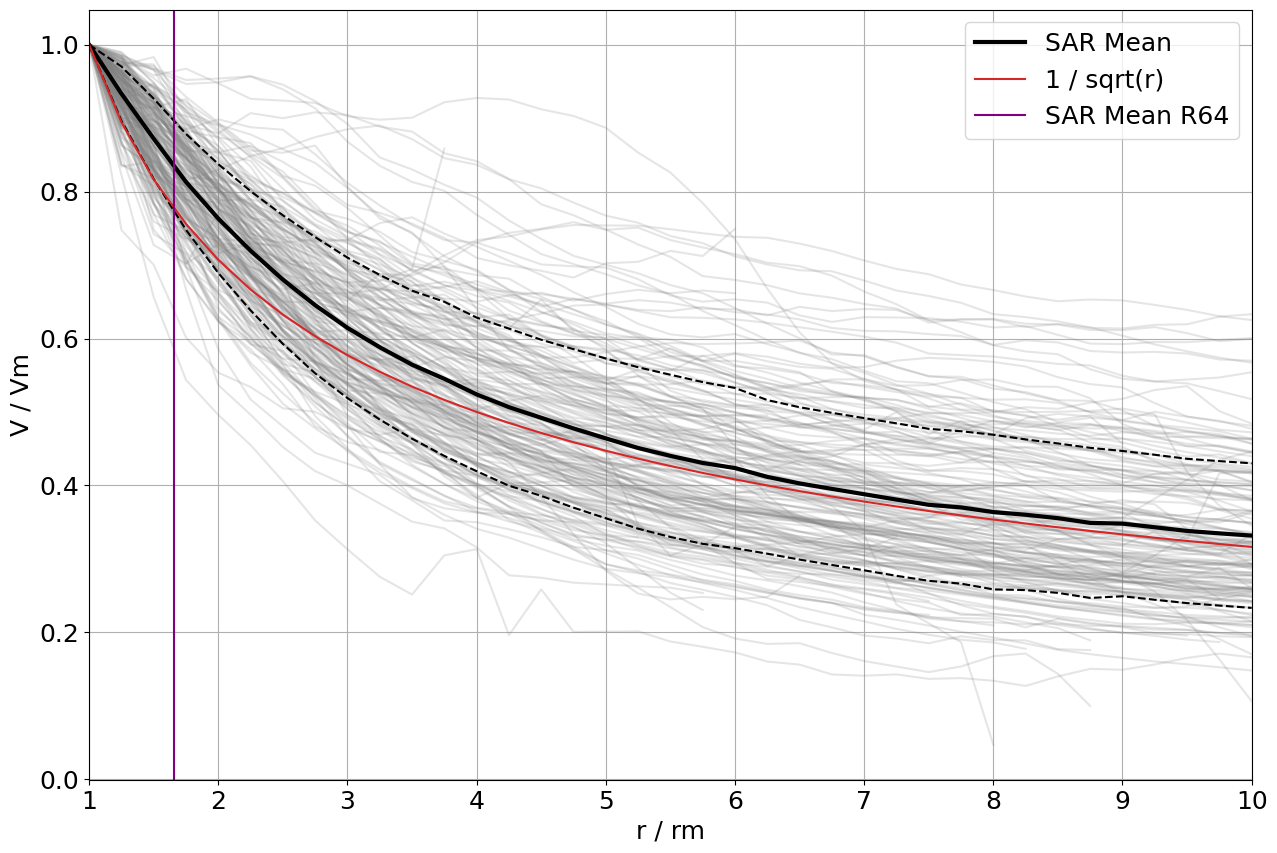

In [6]:
wsm = dss.mean(dim='i').ws
wss = dss.std(dim='i').ws

for i in tqdm(np.arange(len(dss.i))):
    dss.isel(i=i).ws.plot(c='gray', alpha=0.2)
    
wsm.plot(c='k', linewidth=3, label='SAR Mean')
plt.plot(dss.r_star, wsm + wss, c='k', linestyle='dashed')
plt.plot(dss.r_star, wsm - wss, c='k', linestyle='dashed')
(1 / np.sqrt(wsm.r_star)).plot(c='tab:red', label='1 / sqrt(r)')
plt.axvline(dsg.R33_1D.mean() / dsg.Rmax_1D.mean(), c='purple', label='SAR Mean R64')
plt.xlim(1, 10);plt.grid();plt.legend()
plt.ylabel('V / Vm');plt.xlabel('r / rm')

100%|████████████████████████████████████████| 195/195 [00:01<00:00, 166.96it/s]


Concatenating...
Concatenation ended.


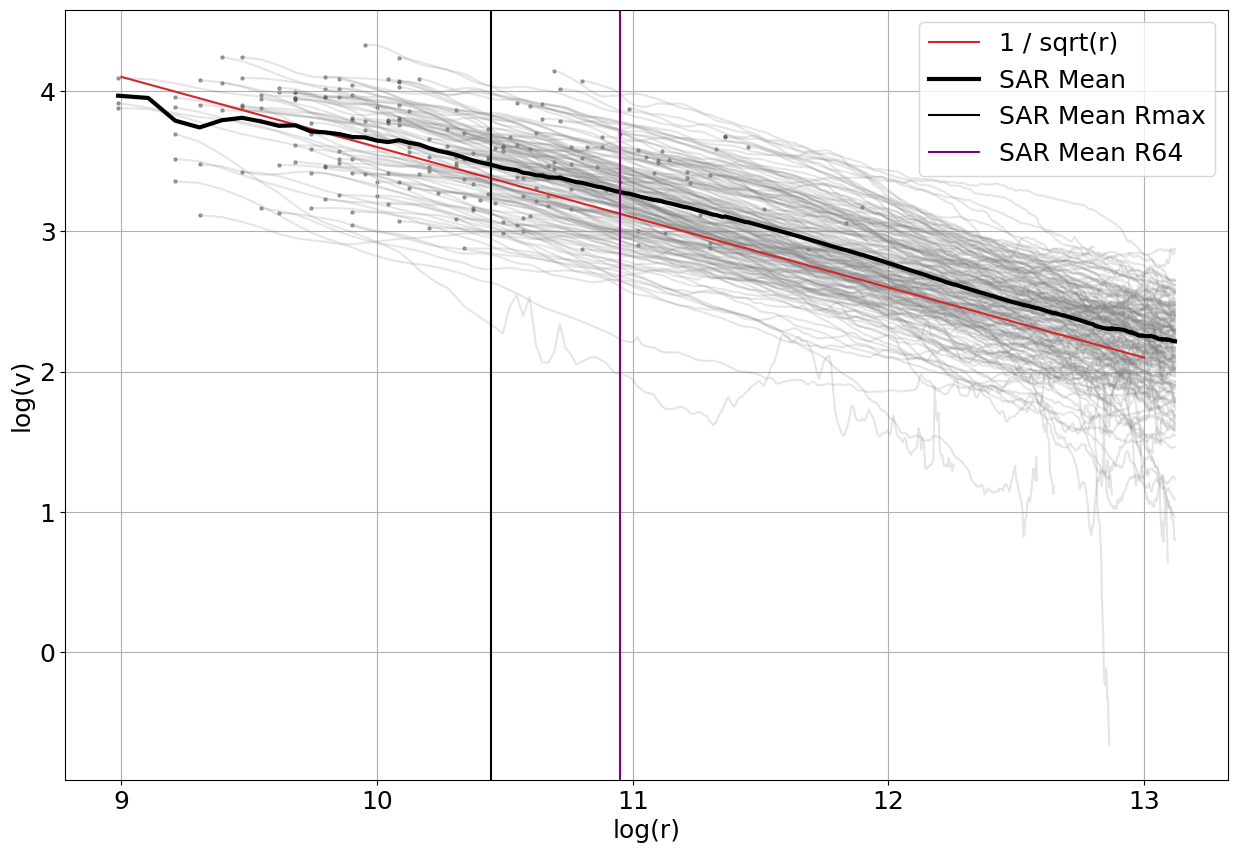

In [7]:
# ITERATE
listOfDatasets = []

for t in tqdm(np.arange(len(DSs.time))):
    ds     = DSs.isel(time=t)
    ds_sel = ds.sel(rad=slice(ds.Rmax_1D * 1000, None))
    plt.plot(np.log(ds_sel.rad), np.log(ds_sel.wind_speed), c='gray', alpha=0.2)
    plt.scatter(np.log(ds_sel.rad[0]), np.log(ds_sel.wind_speed[0]), c='k', s=5, alpha=0.3)
    
    listOfDatasets.append(ds_sel)
    
rs = np.linspace(9, 13, 100)
plt.plot(rs, 8.6 - 0.5 * rs, c='tab:red', label='1 / sqrt(r)')

print('Concatenating...')
dss = xr.concat(listOfDatasets, dim='i')
print('Concatenation ended.')

wsm = dss.mean(dim='i', skipna=True).wind_speed
plt.plot(np.log(wsm.rad), np.log(wsm), c='k', linewidth=3, label='SAR Mean')

plt.axvline(np.log(dsg.Rmax_1D.mean() * 1000),           c='k',      label='SAR Mean Rmax')
plt.axvline(np.log(dsg.R33_1D.mean(skipna=True) * 1000), c='purple', label='SAR Mean R64')

plt.ylabel('log(v)');plt.xlabel('log(r)')

plt.grid();plt.legend()

100%|████████████████████████████████████████| 195/195 [00:01<00:00, 124.61it/s]

Concatenating...
Concatenation ended.


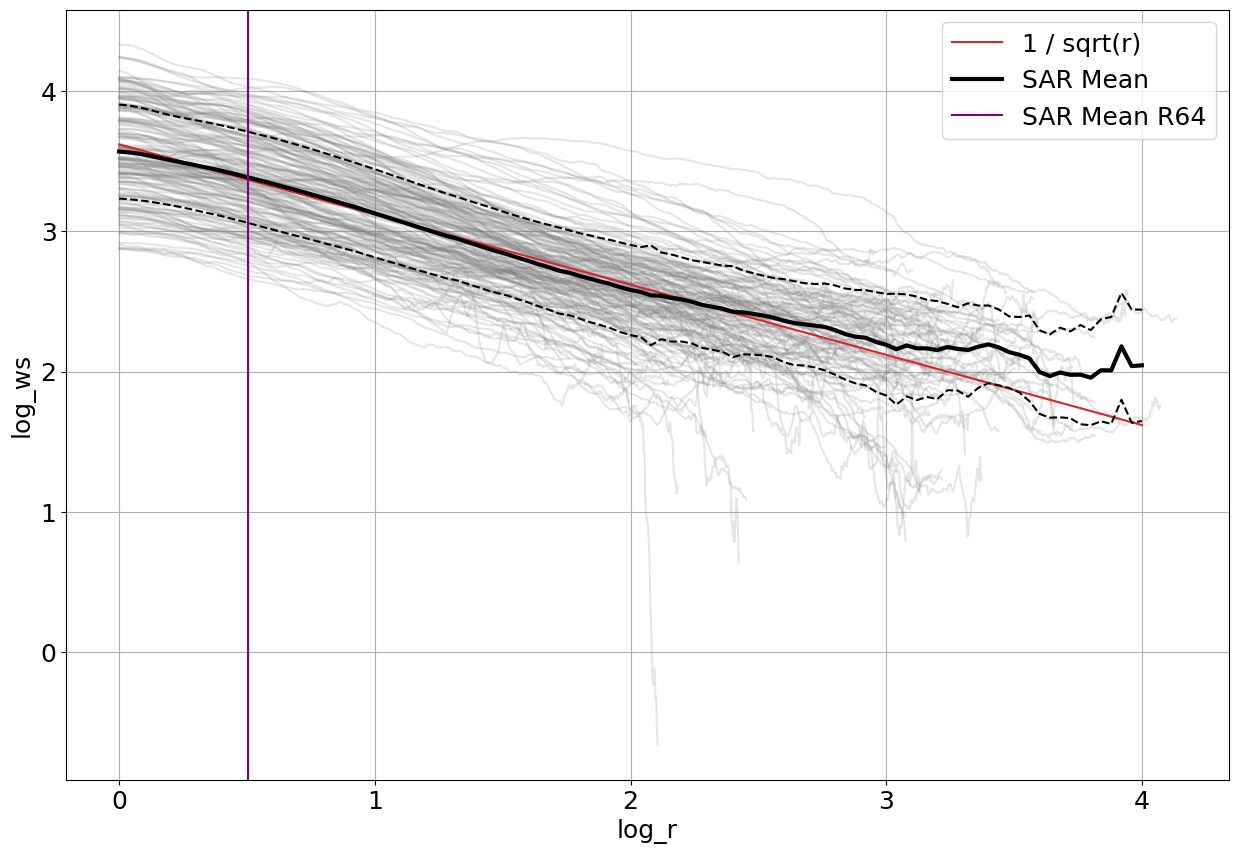

In [8]:
# ITERATE
listOfDatasets = []
log_rf         = np.linspace(0, 4, 101)

for t in tqdm(np.arange(len(DSs.time))):
    ds     = DSs.isel(time=t)
    ds_sel = ds.sel(rad=slice(ds.Rmax_1D * 1000, None))
    plt.plot(np.log(ds_sel.rad) - np.log(ds_sel.rad[0]), np.log(ds_sel.wind_speed), c='gray', alpha=0.2)
    
    dsr = xr.Dataset(
        data_vars={'log_ws': ('log_r', np.array(np.log(ds_sel.wind_speed)))},
        coords={'log_r': np.array(np.log(ds_sel.rad) - np.log(ds_sel.rad[0]))}
    )
    
    listOfDatasets.append(dsr.interp(coords={'log_r': log_rf}))
    
print('Concatenating...')
dss = xr.concat(listOfDatasets, dim='i')
print('Concatenation ended.')
    
rs = np.linspace(0, 4, 100)
plt.plot(rs, 3.62 - 0.5 * rs, c='tab:red', label='1 / sqrt(r)')

log_wsm = dss.log_ws.mean(dim='i', skipna=True)
log_wss = dss.log_ws.std(dim='i', skipna=True)
log_wsm.plot(c='k', linewidth=3, label='SAR Mean')
plt.plot(dss.log_r, log_wsm + log_wss, c='k', linestyle='dashed')
plt.plot(dss.log_r, log_wsm - log_wss, c='k', linestyle='dashed')
plt.axvline(np.log(dsg.R33_1D.mean(skipna=True) * 1000) - np.log(dsg.Rmax_1D.mean(skipna=True) * 1000), c='purple', label='SAR Mean R64')

plt.grid();plt.legend()

100%|█████████████████████████████████████████| 195/195 [00:01<00:00, 99.85it/s]

Concatenating...
Concatenation ended.


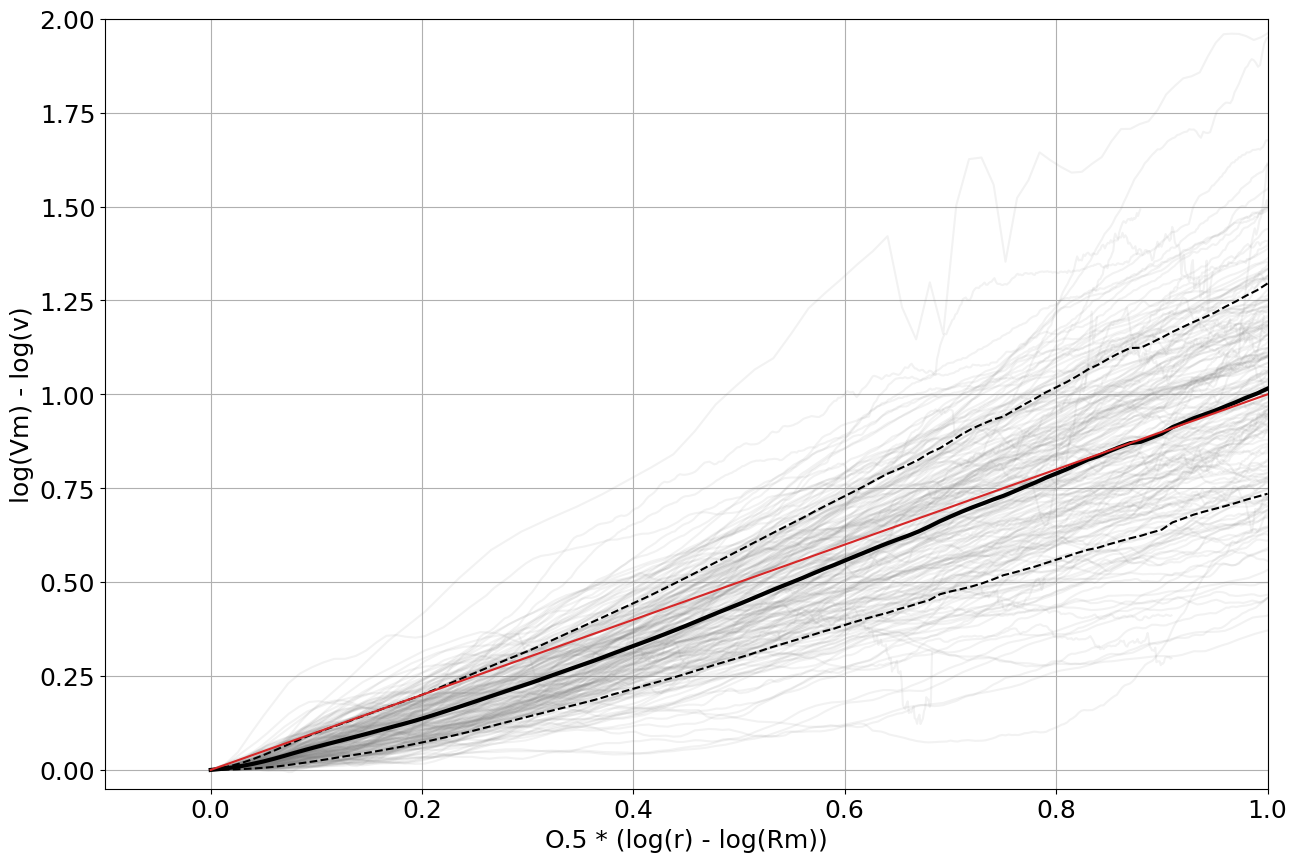

In [9]:
# ITERATE
listOfDatasets = []
xf             = np.linspace(0, 1, 101)
DSs            = dsg.mean(dim='theta', skipna=True)
cmap           = cm.get_cmap('Spectral_r')

for t in tqdm(np.arange(len(DSs.time))):
    ds     = DSs.isel(time=t)
    ds_sel = ds.sel(rad=slice(ds.Rmax_1D * 1000, None))
    plt.plot(0.5 * (np.log(ds_sel.rad) - np.log(ds.Rmax_1D * 1000)), np.log(ds.Vmax_1D) - np.log(ds_sel.wind_speed), c='gray', alpha=0.1)
    
    dsr = xr.Dataset(
        data_vars={'y': ('x', np.array(np.log(ds.Vmax_1D) - np.log(ds_sel.wind_speed))),},
        coords={'x': np.array(0.5 * (np.log(ds_sel.rad) - np.log(ds.Rmax_1D * 1000)))}
    )
    
    listOfDatasets.append(dsr.interp(coords={'x': xf}))

print('Concatenating...')
dss = xr.concat(listOfDatasets, dim='i')
print('Concatenation ended.')
    
lm = dss.y.mean(dim='i', skipna=True)
ls = dss.y.std(dim='i', skipna=True)

plt.plot(dss.x, lm,      c='k', linewidth=3)
plt.plot(dss.x, lm + ls, c='k', linestyle='dashed')
plt.plot(dss.x, lm - ls, c='k', linestyle='dashed')
    
plt.xlabel('O.5 * (log(r) - log(Rm))');plt.ylabel('log(Vm) - log(v)')
plt.xlim(-0.1, 1);plt.ylim(-0.05, 2);plt.grid()
plt.plot([0, 1], [0, 1], c='tab:red')

100%|█████████████████████████████████████████| 195/195 [00:02<00:00, 93.41it/s]


Concatenating...
Concatenation ended.


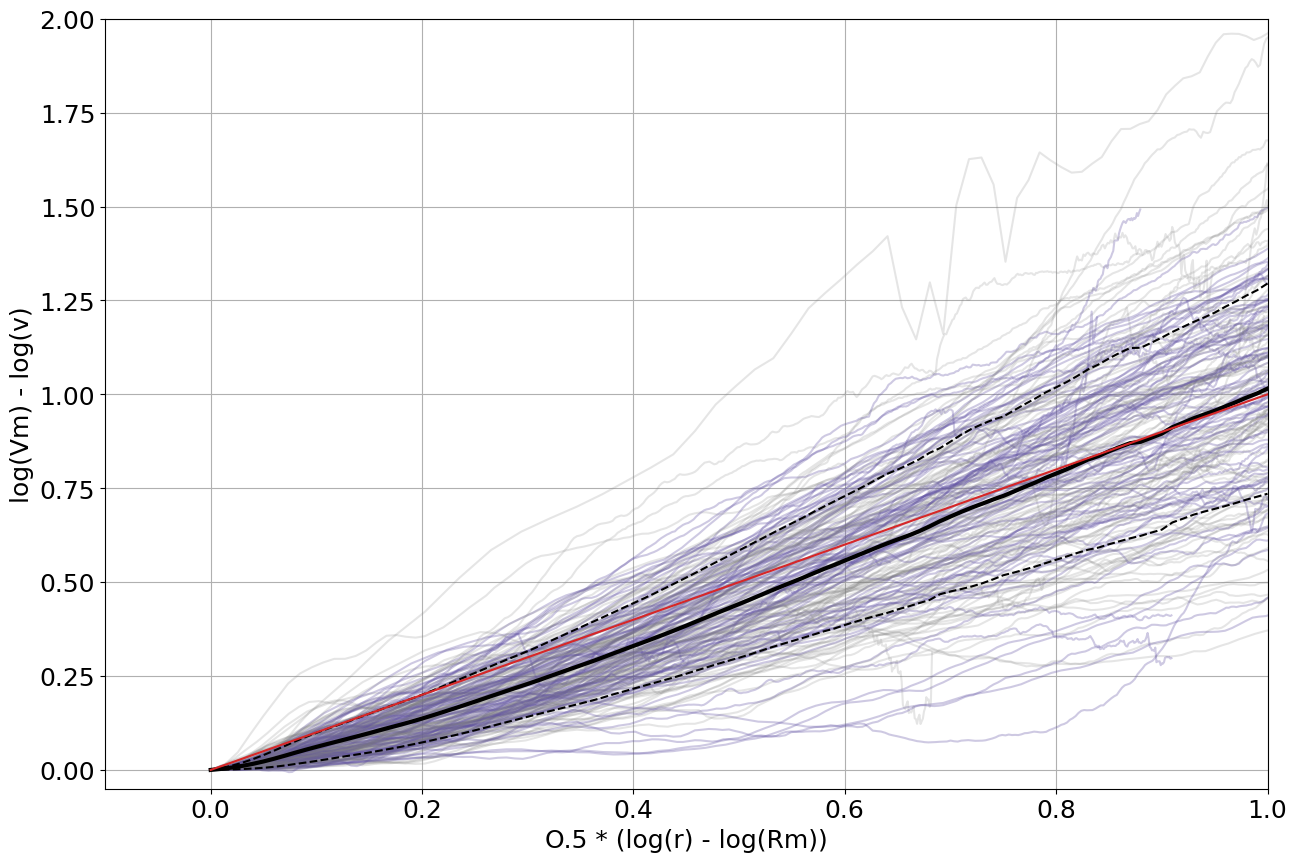

In [10]:
# ITERATE
listOfDatasets = []
xf             = np.linspace(0, 1, 101)
DSs            = dsg.mean(dim='theta', skipna=True)
cmap           = cm.get_cmap('Spectral_r')

for t in tqdm(np.arange(len(DSs.time))):
    ds     = DSs.isel(time=t)
    ds_sel = ds.sel(rad=slice(ds.Rmax_1D * 1000, None))
    if (np.log(abs(ds.dKdt_SAR)) < 35) & (np.log(abs(ds.dKdt_SAR)) > 33):
        plt.plot(0.5 * (np.log(ds_sel.rad) - np.log(ds.Rmax_1D * 1000)), np.log(ds.Vmax_1D) - np.log(ds_sel.wind_speed), c=cmap(0), alpha=0.3)
    else:
        plt.plot(0.5 * (np.log(ds_sel.rad) - np.log(ds.Rmax_1D * 1000)), np.log(ds.Vmax_1D) - np.log(ds_sel.wind_speed), c='gray', alpha=0.2)
    
    dsr = xr.Dataset(
        data_vars={'y': ('x', np.array(np.log(ds.Vmax_1D) - np.log(ds_sel.wind_speed))),},
        coords={'x': np.array(0.5 * (np.log(ds_sel.rad) - np.log(ds.Rmax_1D * 1000)))}
    )
    
    listOfDatasets.append(dsr.interp(coords={'x': xf}))

print('Concatenating...')
dss = xr.concat(listOfDatasets, dim='i')
print('Concatenation ended.')
    
lm = dss.y.mean(dim='i', skipna=True)
ls = dss.y.std(dim='i', skipna=True)

plt.plot(dss.x, lm,      c='k', linewidth=3)
plt.plot(dss.x, lm + ls, c='k', linestyle='dashed')
plt.plot(dss.x, lm - ls, c='k', linestyle='dashed')
    
plt.xlabel('O.5 * (log(r) - log(Rm))');plt.ylabel('log(Vm) - log(v)')
plt.xlim(-0.1, 1);plt.ylim(-0.05, 2);plt.grid()
plt.plot([0, 1], [0, 1], c='tab:red')

In [11]:
def rkne_x(r, vm, rm, x):
    '''Modified Rankine profile'''
    V          = vm * (r / rm)
    V_ou       = vm * (rm / r) ** x
    V[r >= rm] = V_ou[r >= rm]
    return V

vr = rkne_x(np.array(dsg.rad), 50, 40000, 0.5)
# plt.plot(dsg.rad, vr)
# plt.plot(np.log(dsg.rad), np.log(vr))

### Characteristic radius R+

In [12]:
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    # B     = (Vmax ** 2) * rho * np.e / (pn - pc)
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(np.float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

rs = np.linspace(0, 500000, 50001) # define dr accordingly
def vorticity(r, v):
    '''Relative vorticity'''
    dr = 10 # meters
    return (1 / r) * np.gradient(r * v, dr)

100%|████████████████████████████████████████| 195/195 [00:01<00:00, 102.71it/s]


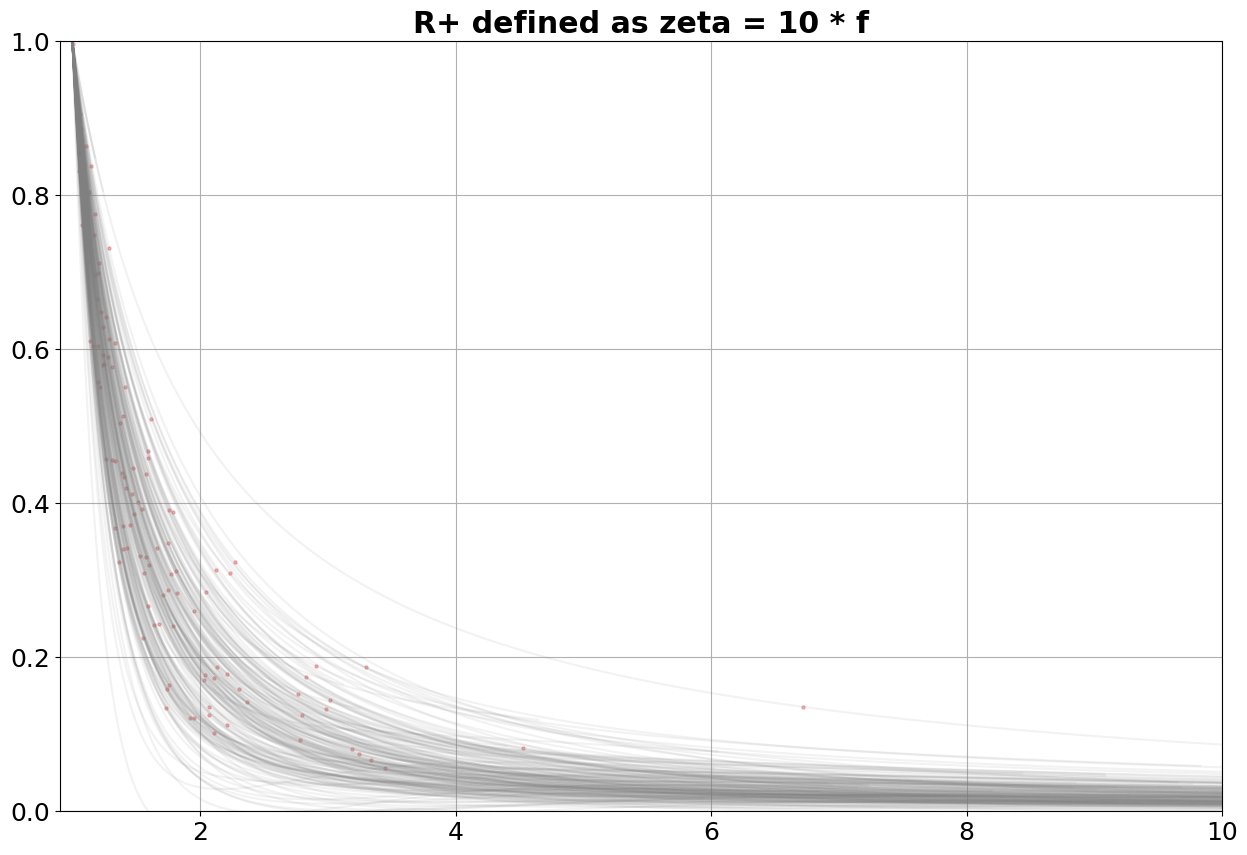

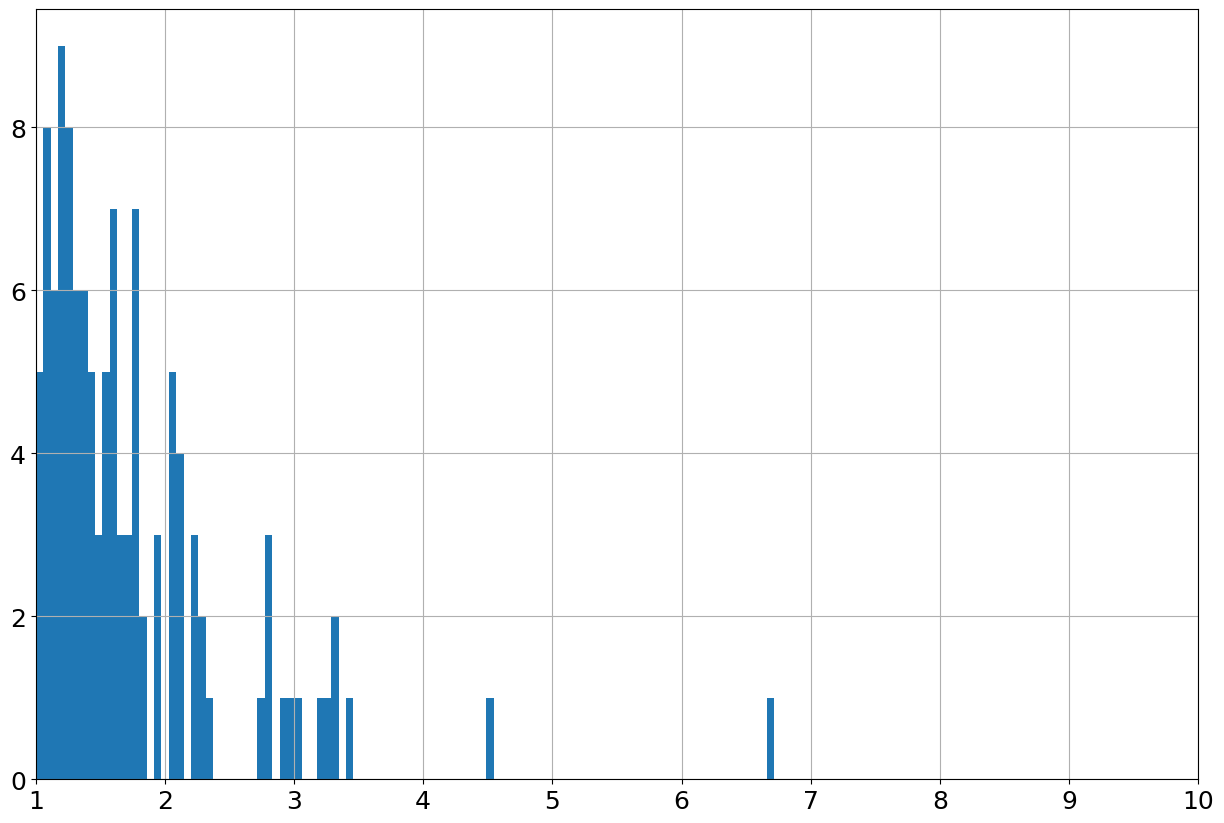

In [13]:
rs = np.linspace(0, 500000, 50001)
n  = 10
RS = []

for t in tqdm(np.arange(len(DSs.time))):
    ds    = DSs.isel(time=t)
    Vh    = holland_profile(rs, float(abs(ds.lat_center)), float(ds.pn_hol), float(ds.pc_hol), float(ds.Vmin_hol), float(ds.Rmax_hol), float(ds.Vmax_hol))
    rm    = float(ds.Rmax_hol)
    out   = rs > rm
    r     = rs[out]
    vrt   = vorticity(rs, Vh)[out]
    
    plt.plot(r / rm, vrt / vrt[0], c='gray', alpha=0.1)
    
    vrt_plan = float(abs(coriolis(ds.lat_center)))
    # R_plus   =  r[abs(vrt - vrt_plan) < 0.1 * vrt[-1]][0]
    try: 
        R_plus =  r[abs(vrt - n * vrt_plan) < 1e-7][0] 
        plt.scatter(R_plus / rm, n * vrt_plan / vrt[0], c='tab:red', s=5, alpha=0.3)
        RS.append(R_plus / rm)
    except IndexError:
        R_plus = np.nan

plt.xlim(0.9, 10);plt.grid();plt.ylim(0, 1)
plt.title('R+ defined as zeta = {} * f'.format(n), weight='bold')
plt.show()

plt.hist(RS, bins=100)
# plt.axvline(np.mean(RS), c='k', linewidth=3)
# plt.axvline(np.mean(RS) + np.std(RS), linestyle='dashed', c='k')
# plt.axvline(np.mean(RS) - np.std(RS), linestyle='dashed', c='k')
plt.xlim(1, 10);plt.grid()

In [14]:
# rs = np.linspace(0, 500000, 50001)
# n  = 10
# RS = []

# for t in tqdm(np.arange(len(DSs.time))):
#     ds    = DSs.isel(time=t)
#     Vh    = holland_profile(rs, float(abs(ds.lat_center)), float(ds.pn_hol), float(ds.pc_hol), float(ds.Vmin_hol), float(ds.Rmax_hol), float(ds.Vmax_hol))
#     rm    = float(ds.Rmax_hol)
#     out   = rs > rm
#     r     = rs[out]
#     vrt   = vorticity(rs, Vh)[out]
#     q     = r * Vh[out] ** 2 / (vrt + float(abs(coriolis(ds.lat_center))))
    
#     if np.nanmax(q) < 1e13:
#         plt.plot(r / rm, q, c='gray', alpha=0.1)
    
#     # plt.plot(r / rm, r * Vh[out] ** 2, c='gray', alpha=0.1)
    
#     vrt_plan = float(abs(coriolis(ds.lat_center)))
#     # R_plus   =  r[abs(vrt - vrt_plan) < 0.1 * vrt[-1]][0]
#     # try: 
#     #     R_plus =  r[abs(vrt - n * vrt_plan) < 1e-7][0] 
#     #     plt.scatter(R_plus / rm, n * vrt_plan / vrt[0], c='tab:red', s=5, alpha=0.3)
#     #     RS.append(R_plus / rm)
#     # except IndexError:
#     #     R_plus = np.nan

# # plt.xlim(0.9, 10);plt.grid();plt.ylim(0, 1)
# plt.show()

# # plt.hist(RS, bins=100)
# # plt.axvline(np.mean(RS), c='k', linewidth=3)
# # plt.axvline(np.mean(RS) + np.std(RS), linestyle='dashed', c='k')
# # plt.axvline(np.mean(RS) - np.std(RS), linestyle='dashed', c='k')
# # plt.xlim(1, 10);plt.grid()